In [211]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
from tqdm import tqdm_notebook
import descartes
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import repeat
%matplotlib inline

# Demo of the crosswalk generation for redlined districts -> 1940 tracts on Manhattan
**Purpose of this crosswalk: two-fold, we (a) need a way to characterize the size of the redlined districts, so we use the number of 1940 tracts they fit into as that measure, and (b) when we're computing entropy, we need to know which district each 1940 tract belonged to.**
Steps are as follows:
1. grab data from shapefiles and preprocess them so each district has a corresponding Polygon, each tract has a corresponding Polygon, and both dataframes are on the same projection
2. go throuh each 1940 tract and assess it's % area overlap with each district. If the total amount of overlap is > 50%, then we assign that tract to the district it is most in overlap with. NOTE: districts can have more than one 1940 tract, that's kind of the purpose of this exercise

In [196]:
nyc_rl_map = gpd.read_file("NYManhattan1937/cartodb-query.shp")
nyc_rl_map

,name,holc_id,holc_grade,geometry
0,None,A1,A,"POLYGON ((-73.96737 40.75281, -73.96679 40.753..."
1,None,A2,A,"POLYGON ((-73.96812 40.76064, -73.97086 40.756..."
2,None,A3,A,"POLYGON ((-73.97323 40.76463, -73.97277 40.765..."
3,None,A4,A,"POLYGON ((-73.95940 40.76952, -73.96064 40.767..."
4,None,A5,A,"POLYGON ((-73.95940 40.76952, -73.96288 40.770..."
5,None,A6,A,"POLYGON ((-73.95597 40.78011, -73.95770 40.777..."
6,None,A7,A,"POLYGON ((-73.95456 40.78813, -73.95481 40.787..."
7,None,A8,A,"POLYGON ((-73.92923 40.86685, -73.92765 40.865..."
8,None,B1,B,"POLYGON ((-73.99770 40.72992, -73.99956 40.730..."
9,None,B10,B,"POLYGON ((-73.92811 40.84768, -73.92970 40.847..."


In [197]:
tracts_1940 = gpd.read_file("data/nhgis0004_shape/nhgis0004_shapefile_tl2008_us_tract_1940/US_tract_1940_conflated.shp")
tracts_1940

,PREFIX,TRACT,SUFFIX,GISJOIN,AREA_UNCLI,STATE,COUNTY,AGGPREFIX,AGGTRACT,AGGSUFFIX,AGGTRACT80,NHGISST,NHGISCTY,ORIG_AREA,Shape_Leng,Shape_Area,geometry
0,None,100,None,G01007300001,1.749567e+06,01,073,None,00010,None,None,010,0730,1.803509e+06,5907.009547,1.749567e+06,"POLYGON ((854493.577 -397256.935, 854472.691 -..."
1,None,200,None,G01007300002,1.554529e+06,01,073,None,00020,None,None,010,0730,1.594264e+06,5463.877185,1.554529e+06,"POLYGON ((853868.242 -398661.126, 853841.476 -..."
2,None,300,None,G01007300003,3.060810e+06,01,073,None,00030,None,None,010,0730,3.116637e+06,12487.796177,3.060810e+06,"POLYGON ((852127.689 -399143.343, 851893.743 -..."
3,None,400,None,G01007300004,3.426404e+06,01,073,None,00040,None,None,010,0730,3.402813e+06,7902.247360,3.426404e+06,"POLYGON ((849845.226 -400382.998, 849700.920 -..."
4,None,500,None,G01007300005,3.240566e+06,01,073,None,00050,None,None,010,0730,3.311872e+06,7447.893459,3.240566e+06,"POLYGON ((850941.107 -402413.869, 850845.273 -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7558,M,1500,None,G1550095M0015,3.234958e+08,15,009,None,M0015,None,None,155,0095,1.464389e+08,64323.997217,1.484161e+08,"POLYGON ((-6050783.155 171924.625, -6050767.21..."
7559,M,1600,None,G1550095M0016,9.072801e+08,15,009,None,M0016,None,None,155,0095,3.639858e+08,95319.867012,3.659123e+08,"MULTIPOLYGON (((-6081815.822 165996.716, -6081..."
7560,M,1700,None,G1550095M0017,7.932966e+08,15,009,None,M0017,None,None,155,0095,3.692857e+08,127072.982891,3.717667e+08,"MULTIPOLYGON (((-6071162.384 205270.496, -6070..."
7561,M,1800,None,G1550095M0018,7.202629e+08,15,009,None,M0018,None,None,155,0095,2.711214e+08,111052.006314,2.732433e+08,"MULTIPOLYGON (((-6060451.687 191842.913, -6060..."


In [198]:
nyc_1940 = tracts_1940.loc[(tracts_1940.STATE == '36') & (tracts_1940.COUNTY == '061')]
nyc_1940 = nyc_1940.filter(['GISJOIN', 'geometry'])
type(nyc_1940.loc[4870].geometry) == shapely.geometry.multipolygon.MultiPolygon
nyc_1940['polygonized'] = [shapely.ops.unary_union(x)[0] if type(x) == shapely.geometry.multipolygon.MultiPolygon 
                           else x 
                           for x in nyc_1940.geometry.values]
nyc_1940.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

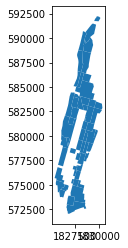

In [199]:
# put the redlining map into the projection of the 1940 tracts
nyc_rl_map = nyc_rl_map.to_crs(nyc_1940.crs)
nyc_rl_map.plot()

In [200]:
# determines what % of polygon a is inside polygon b
area_overlap = lambda a, b: a.intersection(b).area / a.area

In [202]:
crosswalk_1940 = pd.DataFrame({'holc_id': nyc_rl_map.holc_id,
                                'tract_id_1940': [[] for i in range(len(nyc_rl_map.holc_id))]})
crosswalk_1940.set_index('holc_id', inplace=True)
for i in tqdm_notebook(nyc_1940.index): # iterate through the 1940 tracts
    # for each 1940 tract, see it's overlap with each holc_id
    overlaps = np.array(list(map(area_overlap, repeat(nyc_1940.loc[i].polygonized), nyc_rl_map.geometry.values)))
    if sum(overlaps) > 0.5:
        max_district = nyc_rl_map.loc[np.argmax(overlaps)].holc_id
        print(max_district)
        crosswalk_1940.loc[max_district].tract_id_1940.append(nyc_1940.loc[i].GISJOIN[1:])
crosswalk_1940['district_size'] = list(map(len, crosswalk_1940.tract_id_1940.values))
crosswalk_1940

B10
B11
A8
B9
C6
C6
B8
B8
D27
D27
D26
D26
D26
D26
D26
D26
D22
D23
D24
D25
B7
D23
D20
D19
D19
B6
C4
D21
D20
B6
D20
D20
D19
B6
B4
C4
C3
D18
B4
B4
A6
D17
D17
D13
A3
D17
D17
D16
D10
D10
D15
D12
D10
D9
D11
D5
D8
D6
C1
D3
C1
D3
D3
D3
D2
D2
D3
D3
D2
D1
D1
D1
D1
D1



,tract_id_1940,district_size
holc_id,,
A1,[],0
A2,[],0
A3,[3600610004100],1
A4,[],0
A5,[],0
A6,[3600610003600],1
A7,[],0
A8,[3600610000222],1
B1,[],0


Now that we know which 1940 tracts "belong" to which districts, we can figure out the relative sizes of the districts. This'll be helpful for the constellation -> map process, where we have to figure out how often to "cut the snake" (the cut lengths will mimic the distribution of the kde plot below)

For NYC, 71.7% districts had one or more matching 1940 tracts.


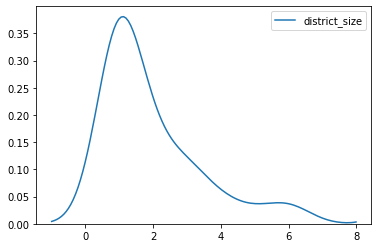

In [213]:
districts_with_similarity = np.round(len(crosswalk_1940.loc[crosswalk_1940.district_size > 0].index) / len(crosswalk_1940.index),3)
print(f"For NYC, {districts_with_similarity * 100}% districts had one or more matching 1940 tracts.")
sns.kdeplot(crosswalk_1940.loc[(crosswalk_1940.district_size > 0)].sort_values('district_size', ascending=False).district_size)

# Future steps
- [ ] repeat for the rest of the cities!